<a href="https://colab.research.google.com/github/stefymojica/MACC/blob/main/modelo_clinico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agente para la optimizacion de recursos en un modelo clinico
## Matematicas aplicadas y ciencias de la computacion
## Estudiante : Stefany Paola Mojica Melo

## **Contextualizacion**

Este agente simula una clinica privada de alta complejidad en horas de la tarde/noche, donde se concentra el mayor flujo de pacientes y la carga asistencial critica

- 1 tick corresponde 1 minutos, 20 ticks corresponde a 20 minutos y asi sucesivamente
- Hay 3 agentes:
  - pacientes
  - medicos
  - triaje
- Hay un modelo
  - Clinica donde los agentes van a interactuar
- En el triaje atienden 2 doctores y aproximadamente se demoran 10 minutos atendiendo a los pacientes
- Hay pacientes de manera aleatoria que llegan en nivel 5 y los envian nuevamente a sus casas
- Los pacientes llegan y el triaje asigna el nivel de riesgo dependiendo de la situacion del paciente
- A la clinica llegan cada 1 hora  entre 15 a 22 pacientes
- Los doctores tienen un tiempo especifico que se toman para tratar a los pacientes de acuerdo a su nivel de criticidad que le haya asignado el triaje
- los pacientes llegan y el triaje les asigana un nivel de criticidad son 5 niveles.
  - nivel 1 - situacion de riesgo vital, requiere accion inmediata
    - Minutos de atencion: 30 minutos maximo
  - nivel 2 - Emergencia. requiere atencion en un tiempo maximo de 30 minutos
    - Minutos de atencion:
  - nivel 3 - Urgencia. se debe atender en un tiempo no mayor a 30 minutos
    - Minutos de atencion:
  - nivel 4 - urgencia menor. Puede esperar hasta 120 minutos
    - Minutos de atencion:
  - nivel 5 - sin urgencia. puede esperar hasta 180 minutos
    - Minutos de atencion:

# **Instalar librerias**

In [1]:
%pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 4.7 MB/s eta 0:00:00


In [2]:
import mesa
print("Versión de Mesa instalada:", mesa.__version__)

Versión de Mesa instalada: 3.3.0


In [6]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random, heapq
import statistics
import matplotlib.pyplot as plt


# **Creacion de Agentes y Modelo**

In [27]:
class SchedulerManual:
    def __init__(self, model):
        self.model = model
        self.agents = []

    def add(self, agent):
        self.agents.append(agent)

    def step(self):
        random.shuffle(self.agents)
        for agent in self.agents:
            agent.step()

class Paciente(Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.unique_id = unique_id
        self.prioridad = None
        self.atendido = False
        self.llegada_tick = model.tick
        self.inicio_atencion_tick = None
        self.fin_atencion_tick = None

    def step(self):
        pass

class Triaje(Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.unique_id = unique_id
        self.ocupado = False
        self.paciente_actual = None
        self.tiempo_restante = 0

    def step(self):
        if self.ocupado:
            self.tiempo_restante -= 1
            if self.tiempo_restante <= 0:
                self.asignar_prioridad(self.paciente_actual)
                self.ocupado = False
                self.paciente_actual = None
            return

        if len(self.model.pacientes_sin_triaje) > 0:
            paciente = self.model.pacientes_sin_triaje.pop(0)
            self.atender(paciente)

    def atender(self, paciente):
        self.ocupado = True
        self.paciente_actual = paciente
        self.tiempo_restante = random.randint(5, 10)

    def asignar_prioridad(self, paciente):
      r = random.random()
      if   r < 0.05: paciente.prioridad = 1
      elif r < 0.15: paciente.prioridad = 2
      elif r < 0.40: paciente.prioridad = 3
      elif r < 0.70: paciente.prioridad = 4
      else:          paciente.prioridad = 5

      heapq.heappush(self.model.cola_prioridad_triaje, (paciente.prioridad, paciente.unique_id, paciente))

      hora_actual = self.model.tick // 60
      self.model.atendidos_triaje_por_hora[hora_actual] = self.model.atendidos_triaje_por_hora.get(hora_actual, 0) + 1

class Doctor(Agent):
    def __init__(self, unique_id, model):
        super().__init__(model)
        self.unique_id = unique_id
        self.ocupado = False
        self.paciente_actual = None
        self.tiempo_restante = 0

    def step(self):
        if self.ocupado:
            self.tiempo_restante -= 1
            if self.tiempo_restante <= 0:
                self.ocupado = False
                self.paciente_actual.fin_atencion_tick = self.model.tick
                self.paciente_actual = None
            return

        if len(self.model.cola_prioridad_triaje) > 0:
            _, _, paciente = heapq.heappop(self.model.cola_prioridad_triaje)
            self.atender(paciente)

    def atender(self, paciente):
        self.ocupado = True
        self.paciente_actual = paciente
        paciente.atendido = True
        paciente.inicio_atencion_tick = self.model.tick
        self.model.pacientes_atendidos += 1

        tiempo_por_prioridad = {1: 20, 2: 15, 3: 12, 4: 10, 5: 8}
        self.tiempo_restante = tiempo_por_prioridad[paciente.prioridad]

class Clinica(Model):
    def __init__(self, n_doctores=3, n_triages=2, semilla=42):
        super().__init__()

        self.semilla = semilla
        if self.semilla is not None:
            random.seed(self.semilla)
            print(f"Semilla de simulación establecida en {self.semilla}")
        else:
            print("No se estableció semilla (resultado no reproducible)")

        self.n_doctores = n_doctores
        self.n_triages = n_triages
        self.pacientes_sin_triaje = []
        self.cola_prioridad_triaje = []
        self.pacientes_atendidos = 0
        self.todos_pacientes = []
        self.tick = 0

        self.atendidos_triaje_por_hora = {}
        self.metricas_por_hora = {
            "hora": [],
            "llegadas": [],
            "atendidos_triaje": [],
            "atendidos_doctores": []
        }

        self.schedule = SchedulerManual(self)

        # Crear doctores
        for d in range(n_doctores):
            self.schedule.add(Doctor(f"D{d+1}", self))

        # Crear triages
        self.triages = []
        for t in range(n_triages):
            tr = Triaje(f"T{t+1}", self)
            self.triages.append(tr)
            self.schedule.add(tr)

    def _llegada_ola(self):
        if self.tick % 60 == 0:
            nuevos = random.randint(15, 22)
            for i in range(nuevos):
                pid = f"P{self.tick}_{i}"
                p = Paciente(pid, self)
                self.schedule.add(p)
                self.pacientes_sin_triaje.append(p)
                self.todos_pacientes.append(p)

    def step(self):
        self._llegada_ola()
        self.schedule.step()
        self.tick += 1

        if self.tick % 60 == 0:
            hora_actual = self.tick // 60
            llegadas = sum(1 for p in self.todos_pacientes if p.llegada_tick // 60 == hora_actual - 1)
            atendidos_triaje = self.atendidos_triaje_por_hora.get(hora_actual - 1, 0)
            atendidos_doctores = sum(1 for p in self.todos_pacientes if p.fin_atencion_tick and p.fin_atencion_tick // 60 == hora_actual - 1)

            self.metricas_por_hora["hora"].append(hora_actual)
            self.metricas_por_hora["llegadas"].append(llegadas)
            self.metricas_por_hora["atendidos_triaje"].append(atendidos_triaje)
            self.metricas_por_hora["atendidos_doctores"].append(atendidos_doctores)

    def mostrar_estado(self):
        h = self.tick // 60
        m = self.tick % 60
        print(f"\n===== MINUTO {self.tick} ({h:02d}:{m:02d}) =====")

        if len(self.cola_prioridad_triaje) == 0:
            print("🟢 Cola de espera para doctor: VACÍA")
        else:
            cola_legible = [(prio, pac.unique_id) for (prio, _, pac) in self.cola_prioridad_triaje]
            print("🟡 Pacientes esperando doctor (prioridad, id):", cola_legible)

        for tr in self.triages:
            if tr.ocupado:
                print(f"🏥 Triaje {tr.unique_id} evaluando a {tr.paciente_actual.unique_id} "
                      f"(restan {tr.tiempo_restante} min)")
            else:
                print(f"✅ Triaje {tr.unique_id} está libre")

        for ag in self.schedule.agents:
            if isinstance(ag, Doctor):
                if ag.ocupado:
                    print(f"👨‍⚕️ Doctor {ag.unique_id} atendiendo a {ag.paciente_actual.unique_id} "
                          f"(restan {ag.tiempo_restante} min)")
                else:
                    print(f"✅ Doctor {ag.unique_id} está libre")

        pacientes_sin_triaje = len(self.pacientes_sin_triaje)
        pacientes_en_triaje = sum(1 for t in self.triages if t.ocupado)
        pacientes_esperando_doctor = len(self.cola_prioridad_triaje)
        total_faltantes = pacientes_sin_triaje + pacientes_en_triaje + pacientes_esperando_doctor

        print(f"📈 Total atendidos: {self.pacientes_atendidos}")
        print(f"⏳ Pacientes sin triaje: {pacientes_sin_triaje}")
        print(f"🩺 Pacientes en triaje: {pacientes_en_triaje}")
        print(f"💬 Pacientes esperando doctor: {pacientes_esperando_doctor}")
        print(f"📊 Pacientes en proceso total: {total_faltantes}")

    def resumen_tiempos(self):
        tiempos_por_prioridad = {1: [], 2: [], 3: [], 4: [], 5: []}
        tiempos_espera = []
        tiempos_totales = []

        for p in self.todos_pacientes:
            if p.inicio_atencion_tick is not None:
                espera = p.inicio_atencion_tick - p.llegada_tick
                tiempos_espera.append(espera)
            if p.fin_atencion_tick is not None:
                total = p.fin_atencion_tick - p.llegada_tick
                tiempos_totales.append(total)
                tiempos_por_prioridad[p.prioridad].append(total)

        if tiempos_espera:
            print(f"\n🕒 Espera promedio hasta ver al doctor: {statistics.mean(tiempos_espera):.1f} min")
            print(f"⏱️ Máximo tiempo de espera: {max(tiempos_espera)} min")

        if tiempos_totales:
            print(f"🏁 Tiempo total promedio desde llegada hasta salida: {statistics.mean(tiempos_totales):.1f} min")
            print(f"📊 Tiempo total máximo desde llegada hasta salida: {max(tiempos_totales)} min")

            print("\n📈 Tiempos promedio por prioridad (desde llegada hasta salida):")
            for prioridad, tiempos in tiempos_por_prioridad.items():
                if tiempos:
                    print(f"Prioridad {prioridad}: Promedio = {statistics.mean(tiempos):.1f} min | "
                          f"Desviación = {statistics.stdev(tiempos) if len(tiempos) > 1 else 0:.1f} min")

    def graficar_metricas(self):
        horas = self.metricas_por_hora["hora"]

        plt.figure(figsize=(10,6))
        plt.plot(horas, self.metricas_por_hora["llegadas"], label="Pacientes llegados", marker='o')
        plt.plot(horas, self.metricas_por_hora["atendidos_triaje"], label="Atendidos en triaje", marker='s')
        plt.plot(horas, self.metricas_por_hora["atendidos_doctores"], label="Atendidos por doctores", marker='^')
        plt.xlabel("Hora simulada")
        plt.ylabel("Número de pacientes")
        plt.title("Flujo de pacientes por hora")
        plt.legend()
        plt.grid(True)
        plt.show()

In [34]:
if __name__ == "__main__":
    clinica = Clinica(n_doctores=2, n_triages=2,semilla=50)
    for _ in range(360):
        clinica.step()
        if clinica.tick % 60 == 0:
            clinica.mostrar_estado()

Semilla de simulación establecida en 50

===== MINUTO 60 (01:00) =====
🟡 Pacientes esperando doctor (prioridad, id): [(4, 'P0_12'), (4, 'P0_8'), (4, 'P0_6')]
🏥 Triaje T1 evaluando a P0_13 (restan 4 min)
🏥 Triaje T2 evaluando a P0_14 (restan 10 min)
👨‍⚕️ Doctor D2 atendiendo a P0_10 (restan 15 min)
👨‍⚕️ Doctor D1 atendiendo a P0_11 (restan 12 min)
📈 Total atendidos: 10
⏳ Pacientes sin triaje: 7
🩺 Pacientes en triaje: 2
💬 Pacientes esperando doctor: 3
📊 Pacientes en proceso total: 12

===== MINUTO 120 (02:00) =====
🟡 Pacientes esperando doctor (prioridad, id): [(3, 'P60_4'), (4, 'P0_21'), (4, 'P0_8'), (4, 'P0_6'), (5, 'P60_2'), (5, 'P0_13'), (5, 'P60_0'), (4, 'P60_1')]
✅ Triaje T1 está libre
🏥 Triaje T2 evaluando a P60_5 (restan 6 min)
👨‍⚕️ Doctor D1 atendiendo a P60_3 (restan 10 min)
👨‍⚕️ Doctor D2 atendiendo a P0_20 (restan 10 min)
📈 Total atendidos: 19
⏳ Pacientes sin triaje: 16
🩺 Pacientes en triaje: 1
💬 Pacientes esperando doctor: 8
📊 Pacientes en proceso total: 25

===== MINUTO 180


🕒 Espera promedio hasta ver al doctor: 102.9 min
⏱️ Máximo tiempo de espera: 179 min
🏁 Tiempo total promedio desde llegada hasta salida: 111.9 min
📊 Tiempo total máximo desde llegada hasta salida: 178 min

📈 Tiempos promedio por prioridad (desde llegada hasta salida):
Prioridad 1: Promedio = 123.0 min | Desviación = 9.9 min
Prioridad 2: Promedio = 102.5 min | Desviación = 37.1 min
Prioridad 3: Promedio = 103.1 min | Desviación = 40.2 min
Prioridad 4: Promedio = 119.1 min | Desviación = 42.2 min
---------


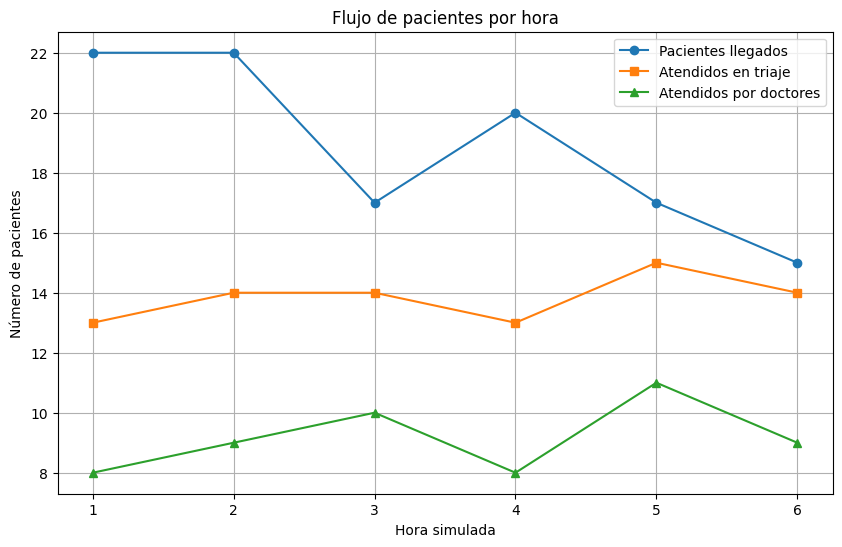

In [35]:
clinica.resumen_tiempos()
print("---------")
clinica.graficar_metricas()

# **Analisis de escenarios**

In [43]:
clinica = Clinica(n_doctores=3, n_triages=3,semilla=50)
for _ in range(360):
    clinica.step()
    if clinica.tick % 180 == 0:
        clinica.mostrar_estado()

Semilla de simulación establecida en 50

===== MINUTO 180 (03:00) =====
🟡 Pacientes esperando doctor (prioridad, id): [(4, 'P120_20'), (5, 'P120_6'), (5, 'P120_13'), (5, 'P60_13'), (5, 'P120_7'), (5, 'P120_19'), (5, 'P120_16'), (5, 'P60_2'), (5, 'P60_6'), (5, 'P120_8'), (5, 'P60_7'), (5, 'P60_3'), (5, 'P120_9'), (5, 'P120_18')]
✅ Triaje T1 está libre
✅ Triaje T2 está libre
✅ Triaje T3 está libre
👨‍⚕️ Doctor D1 atendiendo a P120_15 (restan 6 min)
👨‍⚕️ Doctor D2 atendiendo a P120_14 (restan 8 min)
👨‍⚕️ Doctor D3 atendiendo a P120_17 (restan 10 min)
📈 Total atendidos: 46
⏳ Pacientes sin triaje: 0
🩺 Pacientes en triaje: 0
💬 Pacientes esperando doctor: 14
📊 Pacientes en proceso total: 14

===== MINUTO 360 (06:00) =====
🟡 Pacientes esperando doctor (prioridad, id): [(5, 'P120_18'), (5, 'P120_6'), (5, 'P120_19'), (5, 'P180_10'), (5, 'P120_7'), (5, 'P120_9'), (5, 'P240_1'), (5, 'P180_12'), (5, 'P240_12'), (5, 'P120_8'), (5, 'P240_14'), (5, 'P300_0'), (5, 'P240_13'), (5, 'P60_2'), (5, 'P60_13')


🕒 Espera promedio hasta ver al doctor: 44.1 min
⏱️ Máximo tiempo de espera: 171 min
🏁 Tiempo total promedio desde llegada hasta salida: 55.1 min
📊 Tiempo total máximo desde llegada hasta salida: 179 min

📈 Tiempos promedio por prioridad (desde llegada hasta salida):
Prioridad 1: Promedio = 52.0 min | Desviación = 16.0 min
Prioridad 2: Promedio = 60.1 min | Desviación = 18.3 min
Prioridad 3: Promedio = 49.3 min | Desviación = 18.5 min
Prioridad 4: Promedio = 51.6 min | Desviación = 20.1 min
Prioridad 5: Promedio = 70.8 min | Desviación = 56.2 min
---------


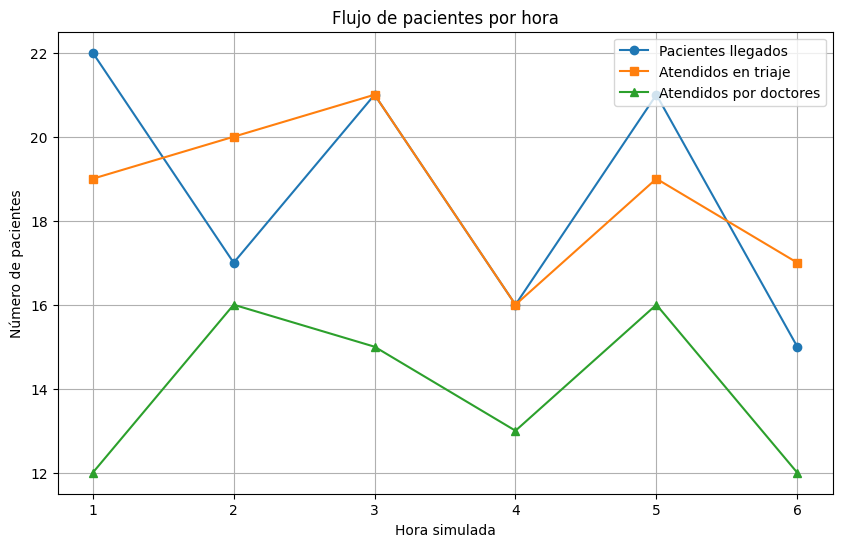

In [44]:
clinica.resumen_tiempos()
print("---------")
clinica.graficar_metricas()